# Augmented Potts Model

In [61]:
import pandas as pd
import numpy as np
import json
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from evcouplings.couplings import CouplingsModel
from Bio import SeqIO

from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR




In [4]:
data_root = Path("../data")

## Compute Hamiltonians for ADK sequences

In [ ]:
small_model = CouplingsModel(data_root / "plmc/adk_175_org.model_params")
seq_dict = dict()
with open(data_root / "175_adk_org_aligned.fasta") as f:
    for record in SeqIO.parse(f, "fasta"):
        seq_dict[record.id] = str(record.seq)
# compute hamiltonians
hamiltonian_array = small_model.hamiltonians(list(seq_dict.values()))
# convert to DataFrame with org_name and global hamiltonian
hamiltonian_df = pd.DataFrame(hamiltonian_array[:,0], index=seq_dict.keys())
hamiltonian_df.reset_index(inplace=True)
hamiltonian_df.rename(columns={"index": "org_name", 0: "potts_175"}, inplace=True)

In [ ]:
big_model = CouplingsModel(data_root / "plmc/big_adk.model_params")
seq_dict = dict()
with open(data_root / "all_adk_representative_seqs_bacdive_aligned.fasta") as f:
    for record in SeqIO.parse(f, "fasta"):
        seq_dict[record.id] = str(record.seq)
# compute hamiltonians
hamiltonian_array = big_model.hamiltonians(list(seq_dict.values()))
# convert to DataFrame with org_name and global hamiltonian
hamiltonian_df_big = pd.DataFrame(hamiltonian_array[:,0], index=seq_dict.keys())
hamiltonian_df_big.reset_index(inplace=True)
hamiltonian_df_big.rename(columns={"index": "org_name", 0: "potts_5149"}, inplace=True)

In [85]:
hamiltonian_df = hamiltonian_df.merge(hamiltonian_df_big, on="org_name", how="inner")

## Dataset Prep

In [86]:
one_hot_encodings = pd.read_csv(data_root / "one_hot_msa_175_orgs.csv")
dataset = pd.read_csv(data_root / 'adk_ml_dataset.csv')
dataset = dataset[["org_name", "log10_kcat", "log10_km"]]

In [87]:
# merge dataset with one-hot encodings and hamiltonians
combined_dataset = pd.merge(one_hot_encodings, hamiltonian_df, on='org_name')
# add a max min norm on the hamiltonian
combined_dataset["potts_175_max_min"] = (combined_dataset["potts_175"] - combined_dataset["potts_175"].min()) / (combined_dataset["potts_175"].max() - combined_dataset["potts_175"].min())
combined_dataset["potts_5149_max_min"] = (combined_dataset["potts_5149"] - combined_dataset["potts_5149"].min()) / (combined_dataset["potts_5149"].max() - combined_dataset["potts_5149"].min())
combined_dataset = pd.merge(combined_dataset, dataset, on='org_name')
combined_dataset.set_index('org_name', inplace=True)

In [88]:
split_dict = json.load(open(data_root / "adk_175_org_bootstrap_stratified_split.json"))

In [ ]:
N_SAMPLES = 30
num_sizes = 1
full_dataset_key = "train_size_140"

targets = ["log10_kcat", "log10_km"]
models = [("SVR", SVR()), ("LR", LinearRegression())]
features = ["one_hot", "potts_175", "potts_175_max_min", "potts_5149", "potts_5149_max_min"]

result_rows = []


for kv in tqdm(list(split_dict.items())):
    split_num = kv[0]
    np.random.seed(int(split_num))
    test_train_dict = kv[1]
    
    test = combined_dataset.loc[test_train_dict["test"]]
    X_test = test.iloc[:, :7263].values

    train = combined_dataset.loc[split_dict[split_num][full_dataset_key]]
    X_train = train.iloc[:, :7263].values
    #X_train_augment = train.iloc[:, :-2].values


    for model_name, model in models:
        for target in targets:
            for feature in features:
                if feature == "one_hot":
                    X_train_ = X_train
                    X_test_ = X_test
                elif feature in combined_dataset.columns:
                    X_train_ = np.hstack((X_train, train[feature].values.reshape(-1, 1)))
                    X_test_ = np.hstack((X_test, test[feature].values.reshape(-1, 1)))
                else:
                    raise ValueError(f"Feature {feature} not found in dataset")

                model.fit(X_train_, train[target].values)
                y_pred = model.predict(X_test_)
                # spearman correlation
                spearman = spearmanr(test[target].values, y_pred)[0]
                result_rows.append({
                    "split_num": split_num,
                    "model": model_name,
                    "target": target,
                    "feature": feature,
                    "spearman": spearman
                })

results_df = pd.DataFrame(result_rows)

100%|██████████| 30/30 [01:50<00:00,  3.68s/it]


In [90]:
results_df["model_target"] = results_df["model"] + "_" + results_df["target"]

<Axes: xlabel='model_target', ylabel='spearman'>

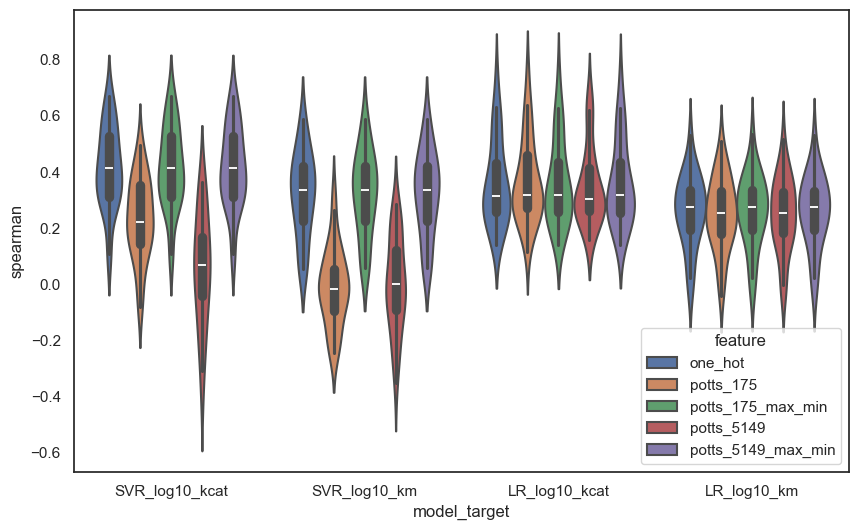

In [91]:
fig = plt.figure(figsize=(10, 6))
sns.set_theme(style="white")
sns.violinplot(x="model_target", y="spearman", hue="feature", data=results_df, linewidth=1.5)